In [3]:
import sys
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install torch


     ---------------------------------------- 0.0/172.3 MB ? eta -:--:--
     --------------------------------------- 0.8/172.3 MB 24.1 MB/s eta 0:00:08
     --------------------------------------- 1.6/172.3 MB 20.5 MB/s eta 0:00:09
      -------------------------------------- 2.7/172.3 MB 21.9 MB/s eta 0:00:08
      -------------------------------------- 4.4/172.3 MB 25.5 MB/s eta 0:00:07
     - ------------------------------------- 6.7/172.3 MB 30.6 MB/s eta 0:00:06
     -- ------------------------------------ 9.6/172.3 MB 36.2 MB/s eta 0:00:05
     --- ---------------------------------- 13.7/172.3 MB 65.6 MB/s eta 0:00:03
     --- ---------------------------------- 17.7/172.3 MB 81.8 MB/s eta 0:00:02
     ---- --------------------------------- 20.7/172.3 MB 81.8 MB/s eta 0:00:02
     ----- -------------------------------- 24.4/172.3 MB 81.8 MB/s eta 0:00:02
     ------ ------------------------------- 28.1/172.3 MB 81.8 MB/s eta 0:00:02
     ------ ------------------------------- 31.

In [1]:
import numpy as np
import pandas as pd

import torch
from sklearn.model_selection import train_test_split

In [42]:
dataset = pd.read_csv('Data/FNN_data.csv')

#subtract the columns L_0_x, L_0_y, L_0_z from all the columns
# for i in range(0, 21):
#     dataset[f'L_{i}_x'] = dataset[f'L_{i}_x'] - dataset['L_0_x']
#     dataset[f'L_{i}_y'] = dataset[f'L_{i}_y'] - dataset['L_0_y']
#     # dataset[f'L_{i}_z'] = dataset[f'L_{i}_z'] - dataset['L_0_z']
#     dataset[f'R_{i}_x'] = dataset[f'R_{i}_x'] - dataset['R_0_x']
#     dataset[f'R_{i}_y'] = dataset[f'R_{i}_y'] - dataset['R_0_y']
#     # dataset[f'R_{i}_z'] = dataset[f'R_{i}_z'] - dataset['R_0_z']

# #write datatset to csv
# dataset.to_csv('Data/relative_data.csv', index=False)

X = dataset.iloc[:, 1:]
Y = dataset.iloc[:, 0]

# choose the columns which names do not end with z
X = X.loc[:, ~X.columns.str.endswith('z')]

# Splitting the dataset into the Training set and Test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

# # Feature Scaling
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

print(X_train)
print(Y_train)


       L_0_x  L_0_y     L_1_x     L_1_y     L_2_x     L_2_y     L_3_x  \
1921     0.0    0.0 -0.004820 -0.057607 -0.019342 -0.119619 -0.020058   
5732     0.0    0.0  0.030582 -0.068452  0.066033 -0.118453  0.098958   
2455     0.0    0.0 -0.013366 -0.054566 -0.039260 -0.100648 -0.047080   
12131    0.0    0.0  0.051912 -0.024143  0.091883 -0.071474  0.110770   
16612    0.0    0.0  0.035078 -0.014762  0.063324 -0.046080  0.070733   
...      ...    ...       ...       ...       ...       ...       ...   
11284    0.0    0.0  0.035475 -0.009871  0.065928 -0.036180  0.079373   
11964    0.0    0.0  0.029539 -0.025970  0.048853 -0.065543  0.044937   
5390     0.0    0.0  0.034163 -0.076962  0.064571 -0.136126  0.093768   
860      0.0    0.0  0.000843 -0.070633  0.034067 -0.136841  0.079285   
15795    0.0    0.0  0.054179 -0.018962  0.092692 -0.067662  0.117693   

          L_3_y     L_4_x     L_4_y  ...    R_16_x    R_16_y    R_17_x  \
1921  -0.143313 -0.001336 -0.115714  ... -0.00512

In [43]:
X_train_tensor = torch.tensor(X_train.values).float()
X_test_tensor = torch.tensor(X_test.values).float()
Y_train_tensor = torch.tensor(Y_train.values).long()
Y_test_tensor = torch.tensor(Y_test.values).long()

In [44]:
print(X_train_tensor.shape)
print(Y_train_tensor.shape)


torch.Size([14400, 84])
torch.Size([14400])


In [45]:
batch_size = 256
n_iters = 10000
num_epochs = n_iters / (len(X_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(X_train_tensor,Y_train_tensor)
test = torch.utils.data.TensorDataset(X_test_tensor,Y_test_tensor)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

In [46]:
class GestureFNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super(GestureFNN, self).__init__()
        # Linear function 1: 126 --> 84
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim_1)

        # Non-linearity 1
        self.relu = torch.nn.ReLU()

        # Linear function 2: 84 --> 2
        self.fc2 = torch.nn.Linear(hidden_dim_1, hidden_dim_2)

        self.relu = torch.nn.ReLU()

        # Linear function 3: 24 --> 2
        self.fc3 = torch.nn.Linear(hidden_dim_2, output_dim)

    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)

        # Non-linearity 1
        out = self.relu(out)

        # Linear function 2 (readout)
        out = self.fc2(out)

        out = self.relu(out)

        out = self.fc3(out)
        return out



In [47]:
# model = GestureFNN(input_dim=126, hidden_dim_1=56, hidden_dim_2=24, output_dim=2)
model = GestureFNN(input_dim=84, hidden_dim_1=40, hidden_dim_2=20, output_dim=2)

critereon = torch.nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [48]:
loss_list = []

for epoch in range(num_epochs):
    for i, (landmarks, labels) in enumerate(train_loader):

        y_pred = model(landmarks)

        loss = critereon(y_pred, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print("epoch = %4d   loss = %0.15f" % (epoch, loss.item()))
        loss_list.append(loss.item())
print("Training done ")

epoch =    0   loss = 0.000002725026206
epoch =   10   loss = 0.000000070780487
epoch =   20   loss = 0.000000094994697
epoch =   30   loss = 0.000000242142733
epoch =   40   loss = 0.000000016763801
epoch =   50   loss = 0.000000013038513
epoch =   60   loss = 0.000000000000000
epoch =   70   loss = 0.000000000000000
epoch =   80   loss = 0.000000011175870
epoch =   90   loss = 0.000000016763803
epoch =  100   loss = 0.000000001862645
epoch =  110   loss = 0.000000003725290
epoch =  120   loss = 0.000000000000000
epoch =  130   loss = 0.000000000000000
epoch =  140   loss = 0.000000001862645
epoch =  150   loss = 0.000000003725290
epoch =  160   loss = 0.000000005587935
epoch =  170   loss = 0.000000000000000
Training done 


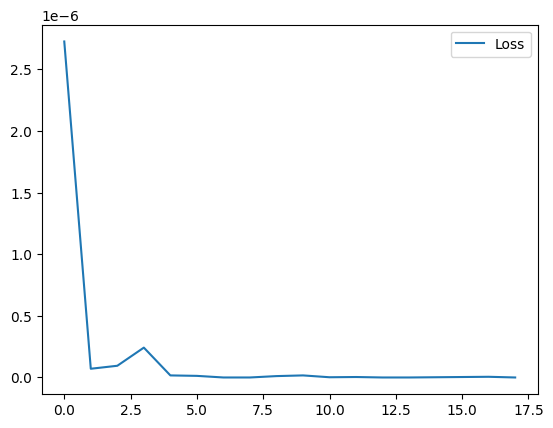

In [49]:
# plot accuracy and loss seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set_style("darkgrid")
# plt.plot(loss_list, label="Loss")
# plt.plot(accuracy_list, label="Accuracy")
# plt.legend()
# plt.show()

# plot the loss
plt.plot(loss_list, label="Loss")
plt.legend()
plt.show()


In [111]:
# save the model
torch.save(model.state_dict(), 'Model/model.pth')

In [50]:
correct = 0
total = 0
with torch.no_grad():
    for i, (landmarks, labels) in enumerate(test_loader):
        y_pred = model(landmarks)
        _, predicted = torch.max(y_pred.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print('Accuracy: %.3f %%' % accuracy)


Accuracy: 100.000 %


In [33]:
import sys
!{sys.executable} -m pip install seaborn

     ---------------------------------------- 0.0/293.3 kB ? eta -:--:--
     -------------------------------------  286.7/293.3 kB 8.9 MB/s eta 0:00:01
     -------------------------------------- 293.3/293.3 kB 6.0 MB/s eta 0:00:00


[[66  0]
 [ 0 82]]


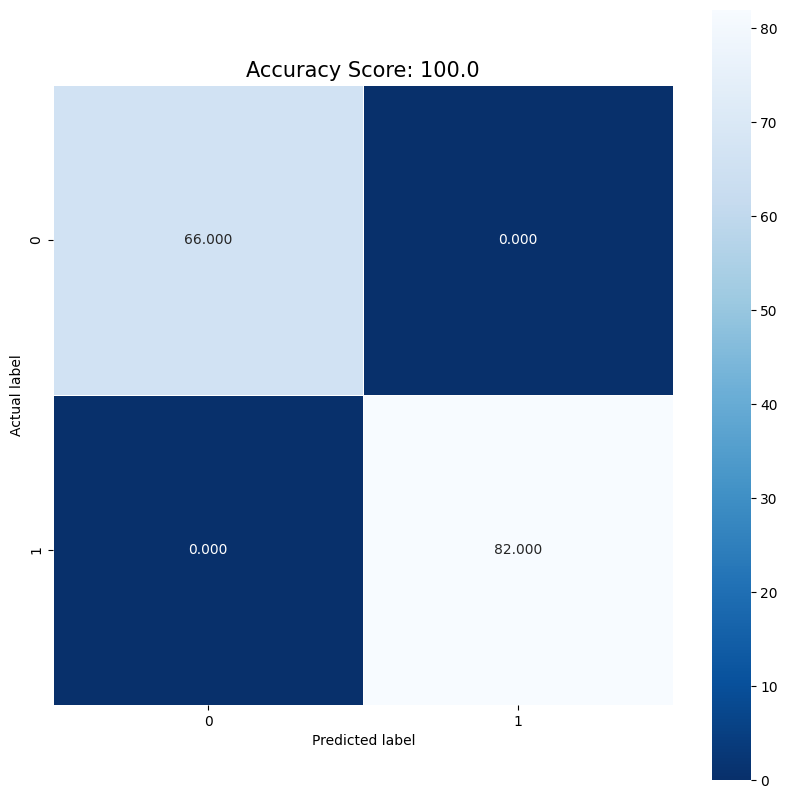

In [110]:
# plot a graphical confusion matrix for the test set using matplotlib
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels, predicted)
print(cm)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size=15)
plt.show()

